<p style="background-color:	#9575CD; font-family: newtimeroman; font-size: 300%; color: #FFF9ED; border-radius: 80px 20px; padding: 25px; text-align: center;"> <b>Flowers CNN Projects</b>

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random as rn

import cv2
from tqdm import tqdm
from random import shuffle
from zipfile import ZipFile
from PIL import Image


In [25]:
pwd

'/content'

In [26]:
my_data= '/content/drive/MyDrive/DL_Flowers_Project/flowers'

In [27]:
os.listdir(my_data)

['sunflower', 'rose', 'dandelion', 'daisy', 'tulip']

In [28]:
X = []
Z = []
IMG_SIZE = 150
FLOWER_DAISY_DIR = my_data + '/daisy/'
FLOWER_SUNFLOWER_DIR = my_data + '/sunflower/'
FLOWER_TULIP_DIR = my_data + '/tulip/'
FLOWER_DANDI_DIR = my_data + '/dandelion/'
FLOWER_ROSE_DIR = my_data + '/rose/'


In [29]:
data_folder = '/content/drive/MyDrive/DL_Flowers_Project/flowers'

import os
import shutil

train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

for flower_class in classes:

    train_class_folder = os.path.join(train_folder, flower_class)
    test_class_folder = os.path.join(test_folder, flower_class)

    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)

import random

split_ratio = 0.8  # Train için %80, Test için %20
for flower_class in classes:
    flower_images = os.listdir(os.path.join(data_folder, flower_class))
    random.shuffle(flower_images)

    split_index = int(len(flower_images) * split_ratio)

    for image in flower_images[:split_index]:
        src = os.path.join(data_folder, flower_class, image)
        dest = os.path.join(train_folder, flower_class, image)
        shutil.copy(src, dest)

    for image in flower_images[split_index:]:
        src = os.path.join(data_folder, flower_class, image)
        dest = os.path.join(test_folder, flower_class, image)
        shutil.copy(src, dest)

In [30]:
train_path = my_data+'/train/'
test_path = my_data+'/test/'
print(os.listdir(train_path))
print(os.listdir(test_path))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


<h2 style="color:#9575CD;">Data Visualization</h2>

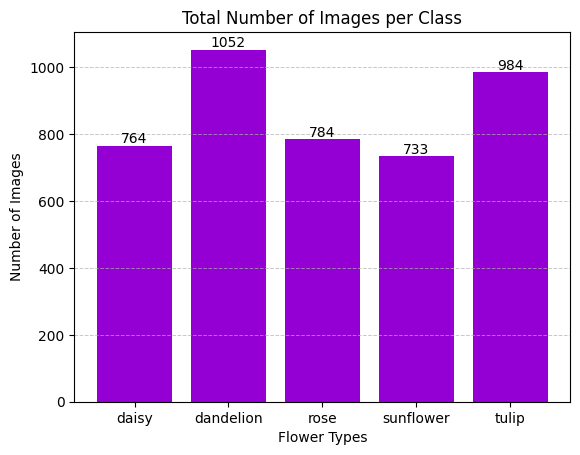

In [34]:
import os
import matplotlib.pyplot as plt

classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

data_dir = '/content/drive/MyDrive/DL_Flowers_Project/flowers'

total_counts = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    num_images = len([fname for fname in os.listdir(class_dir) if fname.endswith('.jpg')])
    total_counts.append(num_images)

plt.bar(classes, total_counts, color='darkviolet')
plt.xlabel('Flower Types')
plt.ylabel('Number of Images')
plt.title('Total Number of Images per Class')
plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.7)

for i, count in enumerate(total_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

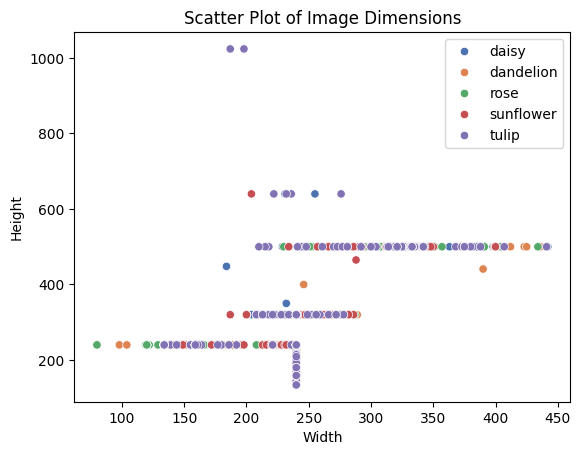

In [35]:
import seaborn as sns
from skimage.io import imread
import os

x = []
y = []
hue = []

for class_name in classes:
    class_dir = os.path.join(train_path, class_name)

    for image_name in os.listdir(class_dir):
        if image_name.endswith('.jpg'):  # Sadece .jpg dosyalarını işle
            img = imread(os.path.join(class_dir, image_name))
            d1, d2, colors = img.shape
            x.append(d1)
            y.append(d2)
            hue.append(class_name)

sns.scatterplot(x=x, y=y, hue=hue, palette="deep")
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Scatter Plot of Image Dimensions')
plt.show()

In [36]:
print(np.mean(x), np.mean(y))

252.84530706836617 338.819235225956


In [37]:
path1=train_path+'/daisy'+"/1342002397_9503c97b49.jpg"

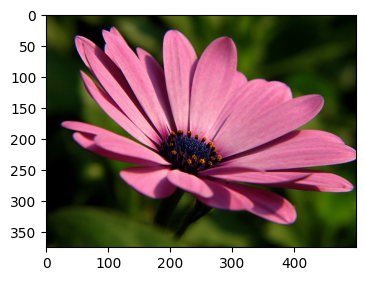

In [38]:
flower_img=imread(path1)
plt.figure(figsize=(4,5))
plt.imshow(flower_img);

In [39]:
flower_img.max()

255

In [40]:
flower_img.min()

0

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

flower_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allowe horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [42]:
flower_img.shape

(375, 500, 3)

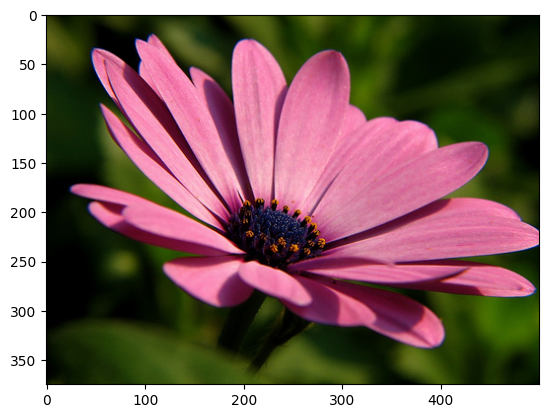

In [43]:
plt.imshow(flower_img)

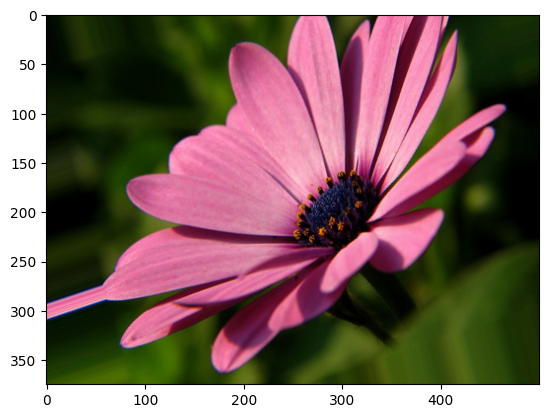

In [44]:
plt.imshow(flower_gen.random_transform(flower_img))

<h1 style="color:#9575CD;">Create the Model</h1>

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [46]:
from tensorflow.keras.layers import BatchNormalization

In [47]:
batch_size = 32
train_flower_gen = flower_gen.flow_from_directory(train_path,

                                               target_size=(224,224),

                                               color_mode='rgb',

                                               batch_size=batch_size,

                                               class_mode='sparse', shuffle=True)

Found 3452 images belonging to 5 classes.


In [48]:
flower_gen_test = ImageDataGenerator()

test_flower_gen = flower_gen_test.flow_from_directory(test_path,

                                                   target_size=(224,224),

                                                   color_mode='rgb',

                                                   batch_size=batch_size,

                                                   class_mode='sparse', shuffle=True)

Found 865 images belonging to 5 classes.


<h1 style="background-color: 		#9575CD	; font-family: newtimeroman; font-size: 300%; color: #FFF9ED; border-radius: 80px 20px; padding: 25px; text-align: center;"> <b>ResNet152</b> 

In [49]:
image_shape = (224, 224, 3)

resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet152(include_top=False,
                                                   input_shape=image_shape,
                                                   pooling='avg',
                                                   weights="imagenet")
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

resnet_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

234698864/234698864 [==============================] - 6s 0us/step


In [50]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 58633861 (223.67 MB)
Trainable params: 262917 (1.00 MB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# restore_best_weights eğitimin erken durdurulması durumunda, modelin ağırlıkları,
# izlenen metriğin en iyi değerini verdiği anda kaydedilen ağırlıklarla değiştirilir.
# Loss degeri belirli bir noktadan sonra artmaya baslayip model durursa, bu parametre sayesinde loss degerinin en dusuk oldugu skorla degistirir.

In [53]:
history_resnet152 = resnet_model.fit(train_flower_gen,epochs=10,
                    validation_data=test_flower_gen,
                    callbacks=[early_stop])

Epoch 1/10
108/108 [==============================] - 96s 755ms/step - loss: 1.5647 - accuracy: 0.2969 - val_loss: 6.3708 - val_accuracy: 0.1769
Epoch 2/10
108/108 [==============================] - 75s 697ms/step - loss: 1.4728 - accuracy: 0.3749 - val_loss: 6.4107 - val_accuracy: 0.1815
Epoch 3/10
108/108 [==============================] - 76s 702ms/step - loss: 1.4487 - accuracy: 0.3890 - val_loss: 5.3970 - val_accuracy: 0.2000
Epoch 4/10
108/108 [==============================] - 76s 696ms/step - loss: 1.4339 - accuracy: 0.3873 - val_loss: 8.9361 - val_accuracy: 0.1792
Epoch 5/10
108/108 [==============================] - 82s 761ms/step - loss: 1.4202 - accuracy: 0.4059 - val_loss: 9.6082 - val_accuracy: 0.1780
Epoch 6/10
108/108 [==============================] - 77s 714ms/step - loss: 1.4015 - accuracy: 0.4235 - val_loss: 8.3194 - val_accuracy: 0.1850


In [54]:
summary = pd.DataFrame(resnet_model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,1.564727,0.296929,6.370832,0.176879
1,1.472836,0.374855,6.410734,0.181503
2,1.448718,0.389050,5.397015,0.200000
3,1.433919,0.387312,8.936112,0.179191
4,1.420234,0.405852,9.608163,0.178035


In [55]:
resnet_model.evaluate(test_flower_gen)

28/28 [==============================] - 7s 247ms/step - loss: 5.3970 - accuracy: 0.2000


[5.397015571594238, 0.20000000298023224]

<h1 style="background-color: 		#9575CD	; font-family: newtimeroman; font-size: 300%; color: #FFF9ED; border-radius: 80px 20px; padding: 25px; text-align: center;"> <b>VGG16</b> 

In [56]:
from tensorflow.keras.applications import VGG16

In [57]:
vgg16_model = Sequential()

pretrained_model = VGG16(include_top=False,
                         input_shape=image_shape,
                         pooling='avg',
                         weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

vgg16_model.add(pretrained_model)

vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dense(5, activation='softmax'))

vgg16_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

vgg16_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 14780997 (56.39 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [58]:
history_vgg16 = vgg16_model.fit(
    train_flower_gen,
    epochs=10,
    validation_data=test_flower_gen,
    callbacks=[early_stop]
)

Epoch 1/10
108/108 [==============================] - 81s 678ms/step - loss: 1.1316 - accuracy: 0.5988 - val_loss: 7.1215 - val_accuracy: 0.6451
Epoch 2/10
108/108 [==============================] - 68s 629ms/step - loss: 0.7797 - accuracy: 0.7257 - val_loss: 9.3314 - val_accuracy: 0.6798
Epoch 3/10
108/108 [==============================] - 68s 625ms/step - loss: 0.6874 - accuracy: 0.7532 - val_loss: 9.9768 - val_accuracy: 0.6994
Epoch 4/10
108/108 [==============================] - 69s 635ms/step - loss: 0.6244 - accuracy: 0.7775 - val_loss: 13.7983 - val_accuracy: 0.6613


In [59]:
summary = pd.DataFrame(vgg16_model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,1.131639,0.598783,7.121512,0.645087
1,0.779666,0.725666,9.331449,0.679769
2,0.687397,0.753187,9.976828,0.699422
3,0.624394,0.777520,13.798250,0.661272


In [60]:
vgg16_model.evaluate(test_flower_gen)

28/28 [==============================] - 5s 183ms/step - loss: 7.1215 - accuracy: 0.6451


[7.121511459350586, 0.6450867056846619]

<h1 style="background-color: 		#9575CD	; font-family: newtimeroman; font-size: 300%; color: #FFF9ED; border-radius: 80px 20px; padding: 25px; text-align: center;"> <b>ConvNeXt Tiny</b> 

In [61]:
import tensorflow_hub as hub

model_url = "https://tfhub.dev/sayakpaul/convnext_tiny_1k_224_fe/1"

pretrained_model = Sequential([
    hub.KerasLayer(model_url, trainable=False, input_shape=(224, 224, 3))
])

convnext_tiny_model = Sequential(pretrained_model)

convnext_tiny_model.add(Dense(128, activation='relu'))
convnext_tiny_model.add(Dense(5, activation='softmax'))

convnext_tiny_model.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

convnext_tiny_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 768)               27820128  
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 27919205 (106.50 MB)
Trainable params: 99077 (387.02 KB)
Non-trainable params: 27820128 (106.13 MB)
_________________________________________________________________


In [62]:
history_convnext_tiny = convnext_tiny_model.fit(
    train_flower_gen,
    epochs=10,
    validation_data=test_flower_gen,
    callbacks=[early_stop]
)

Epoch 1/10
108/108 [==============================] - 89s 719ms/step - loss: 0.6544 - accuracy: 0.7845 - val_loss: 0.6802 - val_accuracy: 0.7225
Epoch 2/10
108/108 [==============================] - 78s 725ms/step - loss: 0.3306 - accuracy: 0.8943 - val_loss: 0.6848 - val_accuracy: 0.7757
Epoch 3/10
108/108 [==============================] - 75s 691ms/step - loss: 0.2701 - accuracy: 0.9119 - val_loss: 0.7184 - val_accuracy: 0.7711
Epoch 4/10
108/108 [==============================] - 76s 699ms/step - loss: 0.2310 - accuracy: 0.9244 - val_loss: 0.8128 - val_accuracy: 0.7572


In [63]:
summary = pd.DataFrame(convnext_tiny_model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,0.654425,0.784473,0.680220,0.722543
1,0.330565,0.894264,0.684807,0.775723
2,0.270053,0.911935,0.718424,0.771098
3,0.231025,0.924392,0.812770,0.757225


In [64]:
convnext_tiny_model.evaluate(test_flower_gen)

28/28 [==============================] - 7s 228ms/step - loss: 0.6802 - accuracy: 0.7225


[0.6802195906639099, 0.7225433588027954]

<h1 style="background-color: 		#9575CD	; font-family: newtimeroman; font-size: 300%; color: #FFF9ED; border-radius: 80px 20px; padding: 25px; text-align: center;"> <b> Xception</b> 

In [65]:
xception_base = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

xception_base.trainable = False

xception_model = Sequential([
    xception_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

xception_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
xception_model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 21124397 (80.58 MB)
Trainable params: 262917 (1.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [66]:
history_xception = xception_model.fit(
    train_flower_gen,
    epochs=10,
    validation_data=test_flower_gen,
    callbacks=[early_stop]
)

Epoch 1/10
108/108 [==============================] - 80s 684ms/step - loss: 0.5934 - accuracy: 0.7769 - val_loss: 27.9266 - val_accuracy: 0.2104
Epoch 2/10
108/108 [==============================] - 70s 645ms/step - loss: 0.3672 - accuracy: 0.8676 - val_loss: 36.1774 - val_accuracy: 0.2277
Epoch 3/10
108/108 [==============================] - 70s 647ms/step - loss: 0.3293 - accuracy: 0.8775 - val_loss: 43.6716 - val_accuracy: 0.2266
Epoch 4/10
108/108 [==============================] - 70s 644ms/step - loss: 0.3012 - accuracy: 0.8902 - val_loss: 47.9015 - val_accuracy: 0.2081


In [67]:
summary = pd.DataFrame(xception_model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,0.593432,0.776941,27.926626,0.210405
1,0.367192,0.867613,36.177387,0.227746
2,0.329284,0.877462,43.671600,0.226590
3,0.301223,0.890209,47.901489,0.208092


In [68]:
xception_model.evaluate(test_flower_gen)

28/28 [==============================] - 6s 201ms/step - loss: 27.9266 - accuracy: 0.2104


[27.926624298095703, 0.21040461957454681]

<h1 style="background-color: 		#9575CD	; font-family: newtimeroman; font-size: 300%; color: #FFF9ED; border-radius: 80px 20px; padding: 25px; text-align: center;"> <b> EfficientNetV2-S</b> 

In [69]:
from tensorflow.keras.applications import EfficientNetV2S

efficientnet_v2s = EfficientNetV2S(include_top=False,
                                   weights='imagenet',
                                   input_shape=(224, 224, 3))

efficientnet_v2s.trainable = False

efficientnet_v2s_model = Sequential([
    efficientnet_v2s,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

efficientnet_v2s_model.compile(optimizer='adam',
                               loss='sparse_categorical_crossentropy',
                               metrics=['accuracy'])

efficientnet_v2s_model.summary()

82420632/82420632 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 20495973 (78.19 MB)
Trainable params: 164613 (643.02 KB)
Non-trainable params: 20331360 (77.56 MB)
________

In [71]:
history_efficientnetv2_s = efficientnet_v2s_model.fit(
    train_flower_gen,
    epochs=10,
    validation_data=test_flower_gen,
    callbacks=[early_stop]
)

Epoch 1/10
108/108 [==============================] - 93s 694ms/step - loss: 1.4821 - accuracy: 0.3673 - val_loss: 1.6859 - val_accuracy: 0.2497
Epoch 2/10
108/108 [==============================] - 70s 648ms/step - loss: 1.4179 - accuracy: 0.3992 - val_loss: 1.8015 - val_accuracy: 0.2983
Epoch 3/10
108/108 [==============================] - 69s 643ms/step - loss: 1.3919 - accuracy: 0.4070 - val_loss: 1.8912 - val_accuracy: 0.2960
Epoch 4/10
108/108 [==============================] - 69s 643ms/step - loss: 1.3592 - accuracy: 0.4270 - val_loss: 2.0260 - val_accuracy: 0.3110


In [72]:
summary = pd.DataFrame(efficientnet_v2s_model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,1.482135,0.367323,1.685882,0.249711
1,1.417892,0.399189,1.801521,0.298266
2,1.391878,0.407010,1.891201,0.295954
3,1.359204,0.426999,2.025981,0.310983


In [73]:
efficientnet_v2s_model.evaluate(test_flower_gen)

28/28 [==============================] - 6s 219ms/step - loss: 1.6859 - accuracy: 0.2497


[1.6858817338943481, 0.24971097707748413]

<h2 style="color: #9575CD	;">Model Performance </h2>

In [74]:
import matplotlib.pyplot as plt

def plot_model_performance(history, title='Model Performance'):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Acc')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

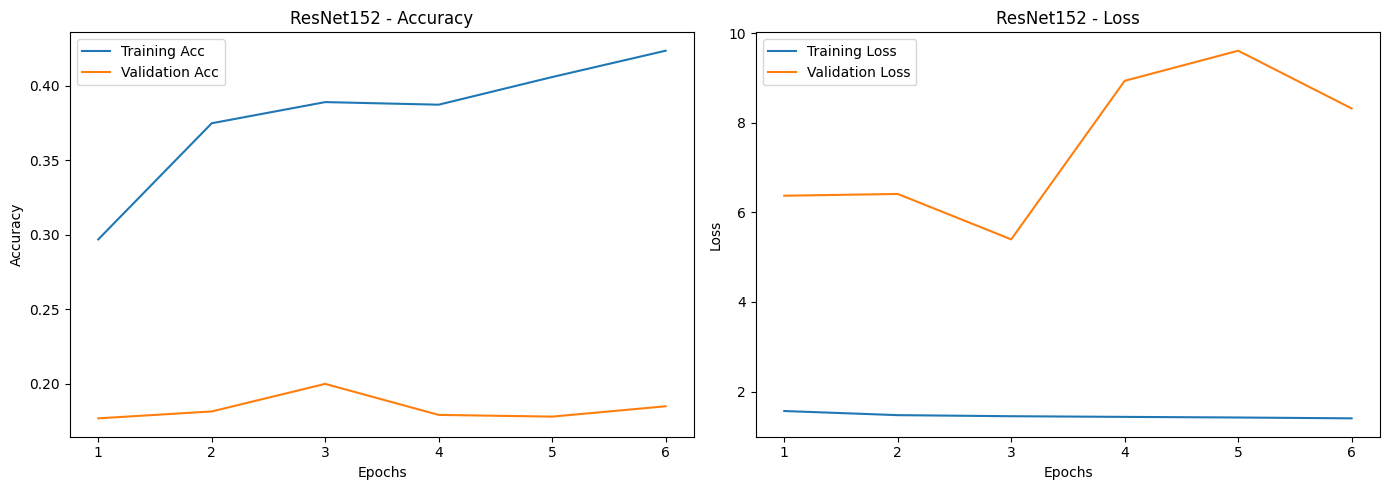

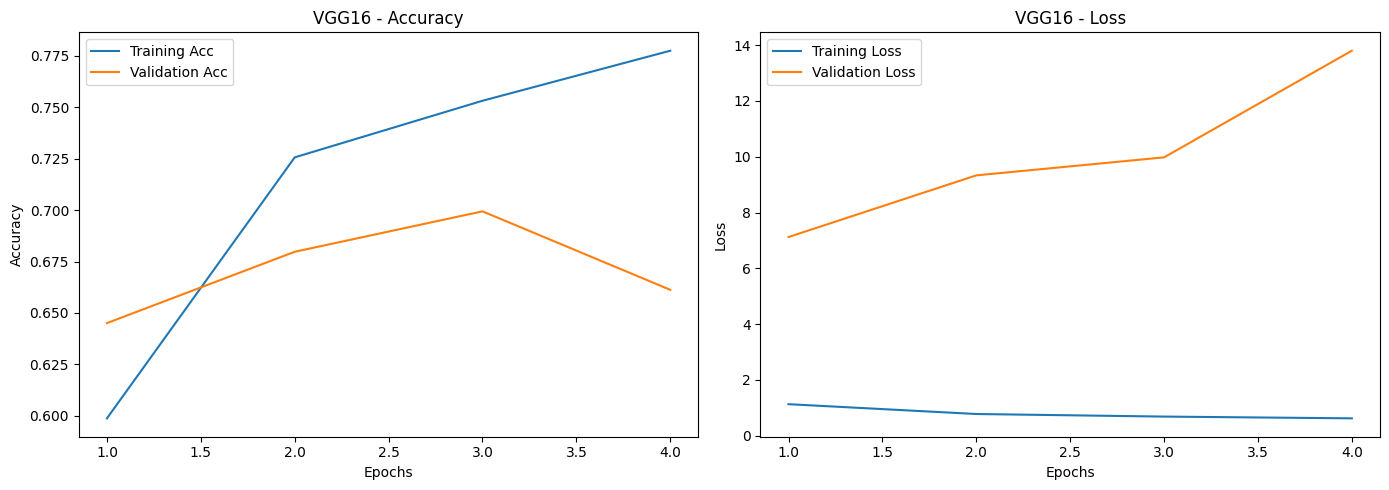

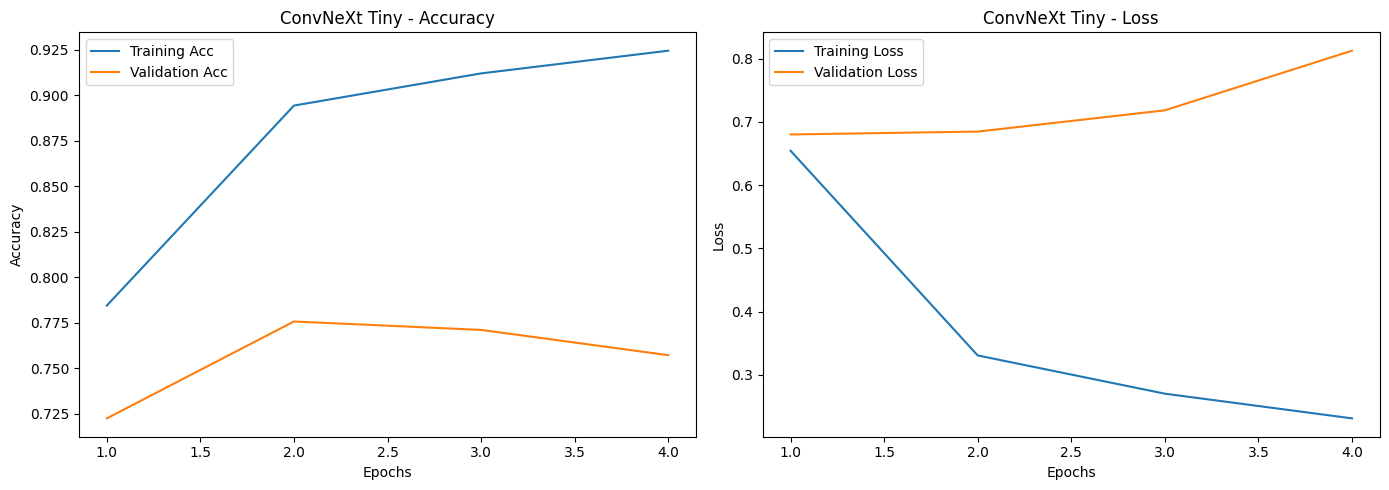

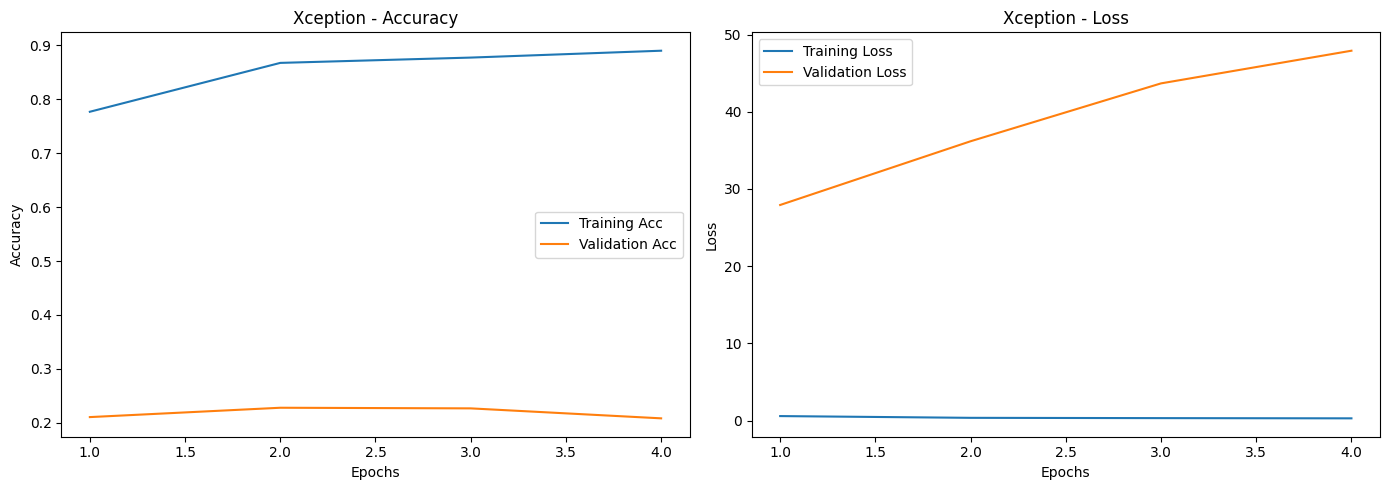

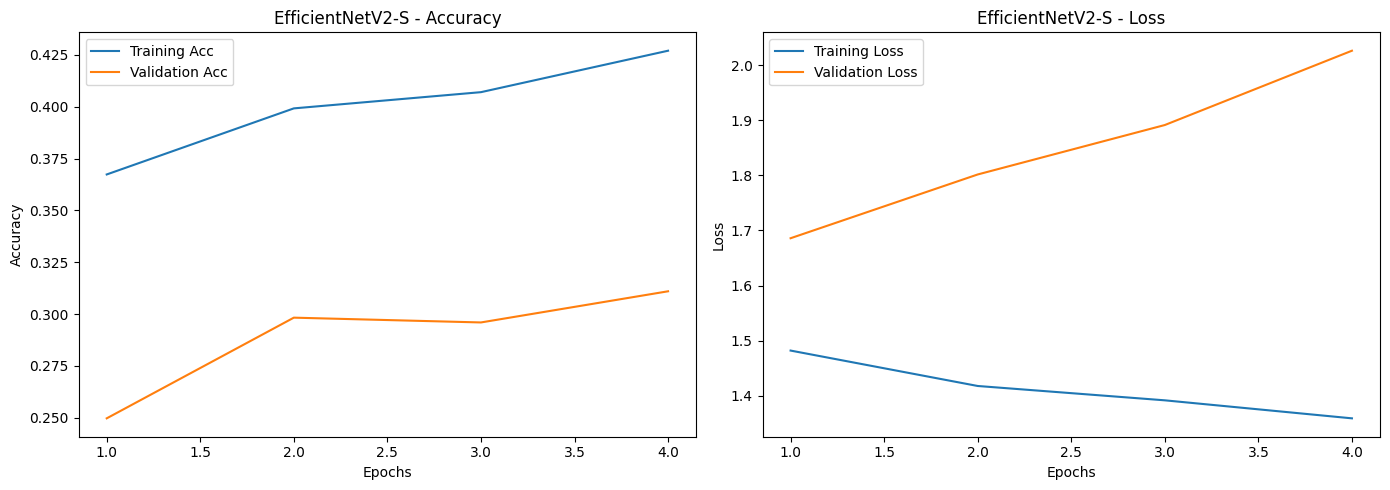

In [75]:
plot_model_performance(history_resnet152, 'ResNet152')

plot_model_performance(history_vgg16, 'VGG16')

plot_model_performance(history_convnext_tiny, 'ConvNeXt Tiny')

plot_model_performance(history_xception, 'Xception')

plot_model_performance(history_efficientnetv2_s, 'EfficientNetV2-S')

<h1 style="background-color: 	#9575CD	; font-family: newtimeroman; font-size: 300%; color: #FFF9ED; border-radius: 80px 20px; padding: 25px; text-align: center;"> <b>Final Model</b> 

In [76]:
convnext_tiny_model.metrics_names

['loss', 'accuracy']

In [77]:
convnext_tiny_model.evaluate(test_flower_gen)

28/28 [==============================] - 7s 243ms/step - loss: 0.6802 - accuracy: 0.7225


[0.6802195310592651, 0.7225433588027954]

In [78]:
from tensorflow.keras.preprocessing import image

In [79]:
pred_probabilities = convnext_tiny_model.predict(test_flower_gen)

28/28 [==============================] - 8s 244ms/step


In [80]:
pred_probabilities

array([[6.2901117e-02, 1.3416074e-02, 3.1413570e-02, 4.4636756e-01,
        4.4590163e-01],
       [6.9580966e-01, 3.0198023e-01, 8.1127228e-06, 2.0192065e-03,
        1.8283323e-04],
       [1.8233352e-03, 2.5133722e-04, 9.9034941e-01, 1.4265375e-03,
        6.1494038e-03],
       ...,
       [2.6082670e-04, 5.0612918e-05, 9.9522614e-01, 3.7229387e-04,
        4.0900907e-03],
       [1.8434133e-02, 5.4026037e-01, 1.8513949e-01, 4.9183197e-02,
        2.0698281e-01],
       [5.3538370e-01, 3.6718327e-01, 3.6057740e-04, 9.6863382e-02,
        2.0900385e-04]], dtype=float32)

In [81]:
test_flower_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [82]:
pred_probabilities

array([[6.2901117e-02, 1.3416074e-02, 3.1413570e-02, 4.4636756e-01,
        4.4590163e-01],
       [6.9580966e-01, 3.0198023e-01, 8.1127228e-06, 2.0192065e-03,
        1.8283323e-04],
       [1.8233352e-03, 2.5133722e-04, 9.9034941e-01, 1.4265375e-03,
        6.1494038e-03],
       ...,
       [2.6082670e-04, 5.0612918e-05, 9.9522614e-01, 3.7229387e-04,
        4.0900907e-03],
       [1.8434133e-02, 5.4026037e-01, 1.8513949e-01, 4.9183197e-02,
        2.0698281e-01],
       [5.3538370e-01, 3.6718327e-01, 3.6057740e-04, 9.6863382e-02,
        2.0900385e-04]], dtype=float32)

In [83]:
from sklearn.metrics import classification_report,confusion_matrix

In [84]:
test_flower_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [112]:
from google.colab import drive
drive.mount('/content/drive')

# Bağlantıyı ve dizini kontrol edin
!echo "Drive İçeriği:"
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive İçeriği:
'Colab Notebooks'   DL_Flowers_Project


In [130]:
model_save_path = '/content/drive/MyDrive/flowers_model'
convnext_tiny_model.save(model_save_path)

<h2 style="color: crimson;">Predicting on an Image </h2>

In [118]:
train_flower_gen.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [131]:
import numpy as np
import tensorflow as tf
from PIL import Image

model = tf.keras.models.load_model(
    model_save_path,
    custom_objects={'KerasLayer': hub.KerasLayer}
)
image = Image.open('/content/drive/MyDrive/DL_Flowers_Project/tulip.jpg')
image = image.resize((224, 224))
image_array = np.array(image.convert('RGB')) / 255.0
image_array = np.expand_dims(image_array, axis=0)

prediction = model.predict(image_array)

predicted_class = np.argmax(prediction)
print('Tahmin edilen sınıf:', predicted_class)

1/1 [==============================] - 1s 962ms/step
Tahmin edilen sınıf: 4
